# Clustering Homework Assignment
Matthew Paras

1/14/2019

Data found at: https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Physician-and-Other-Supplier2016.html

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Read in the data
output = pd.read_csv('chicago_data.csv')

### Feature Demographics

In [12]:
# HCPCS_CODE Mapping to Description
hcpcs_codes = output[['HCPCS_CODE', 'HCPCS_DESCRIPTION']].drop_duplicates()

# Generate Demographics

# Number of different providers
print("Number of unique providers: ", output['NPI'].nunique())
      
# Number of different HCPCS_codes:
print("Number of different HCPCS_codes: ", output['HCPCS_CODE'].nunique())

# Gender Demographics
print("Gender Demographics: ")
print(output['NPPES_PROVIDER_GENDER'].value_counts())

# HCPCS Demographics
print("HCPCS Codes: ")
print(output['HCPCS_CODE'].nunique())

# Entity Code Demographics
print("Entity Code Demographics: ")
print(output['NPPES_ENTITY_CODE'].value_counts())

# Number of Zip Codes Represented:
print("Zip Codes: ")
print(output['NPPES_PROVIDER_ZIP'].nunique())

# Number of place of services Represented:
print("Places of Service: ")
print(output['PLACE_OF_SERVICE'].value_counts())

# Drug Indicator:
print("Drug Indicator: ")
print(output['HCPCS_DRUG_INDICATOR'].value_counts())

Number of unique providers:  9837
Number of different HCPCS_codes:  2036
Gender Demographics: 
M    54398
F    29501
Name: NPPES_PROVIDER_GENDER, dtype: int64
HCPCS Codes: 
2036
Entity Code Demographics: 
I    83899
Name: NPPES_ENTITY_CODE, dtype: int64
Zip Codes: 
67
Places of Service: 
F    43432
O    40467
Name: PLACE_OF_SERVICE, dtype: int64
Drug Indicator: 
N    80182
Y     3717
Name: HCPCS_DRUG_INDICATOR, dtype: int64


## Feature Histograms

In [14]:
# select features that we want to cluster on
selected_data = pd.concat([output[['LINE_SRVC_CNT', 'AVERAGE_MEDICARE_STANDARD_AMT']], 
                           pd.get_dummies(output['PLACE_OF_SERVICE']),
                           pd.get_dummies(output['NPPES_PROVIDER_GENDER'])], axis = 1)


# selected_data = output[['Lat','Long']]
# cluster on LINE_SRVC_CNT, AVERAGE_MEDICARE_STANDARD_AMT, NPPES_PROVIDER_GENDER
# selected_data

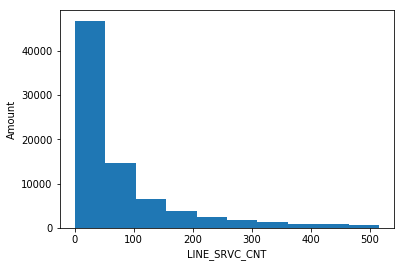

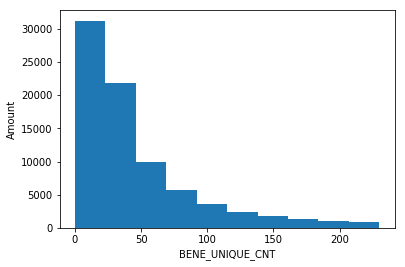

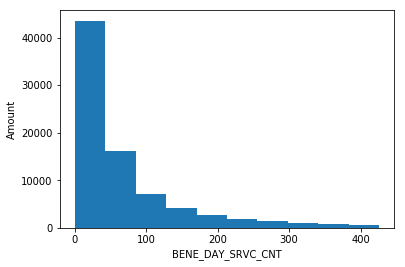

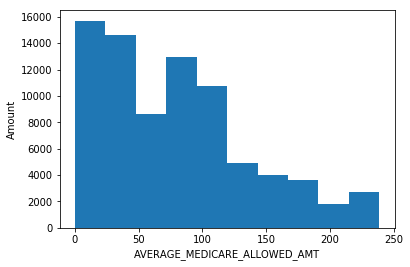

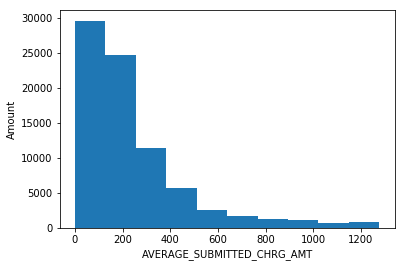

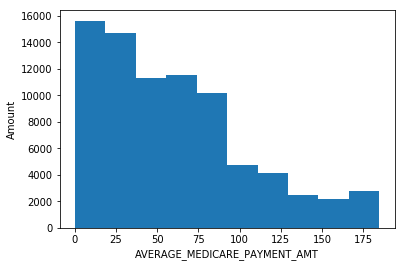

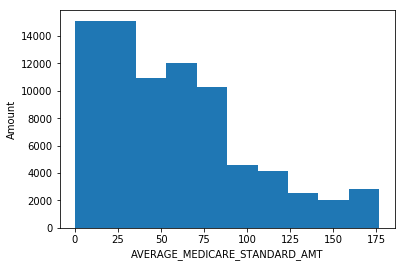

In [15]:
numeric_data = output._get_numeric_data()
column_names = list(numeric_data)[2:]

for column_name in column_names:
    # plt.figure(figsize=(10,5))
    # find percentile
    upper_bound = np.percentile(numeric_data[column_name], 95)
    plt.hist(numeric_data[column_name], range = (0, upper_bound))
    plt.xlabel(column_name)
    plt.ylabel("Amount")
    plt.show()

In [16]:
# scale the data (currently only scale the numeric data)
# mms = MinMaxScaler()
# numeric_data = output._get_numeric_data()
# df_scaled = pd.DataFrame(mms.fit_transform(numeric_data), columns = numeric_data.columns)
# df_scaled = df_scaled[df_scaled.columns[2:]]
numeric_data = pd.DataFrame(preprocessing.scale(selected_data), columns = selected_data.columns)

## Elbow method for determining the optimal number of clusters

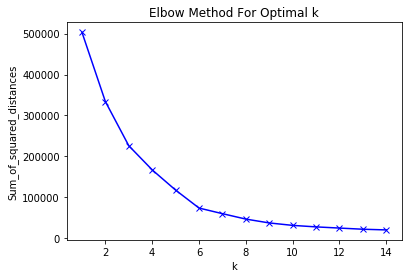

In [17]:
# Elbow method for determining the optimal number of clusters
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(numeric_data)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## Silhouette Analysis

Adapted from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

For n_clusters = 2 The average silhouette_score is : 0.5014393627600267
For n_clusters = 3 The average silhouette_score is : 0.6513966861060004
For n_clusters = 4 The average silhouette_score is : 0.6561384036761084
For n_clusters = 5 The average silhouette_score is : 0.7854284943056873
For n_clusters = 6 The average silhouette_score is : 0.8032503301965597
For n_clusters = 7 The average silhouette_score is : 0.8106385377831983
For n_clusters = 8 The average silhouette_score is : 0.8154185508981553
For n_clusters = 9 The average silhouette_score is : 0.8161898284585932
For n_clusters = 10 The average silhouette_score is : 0.7415005587344172
For n_clusters = 11 The average silhouette_score is : 0.675070328386609


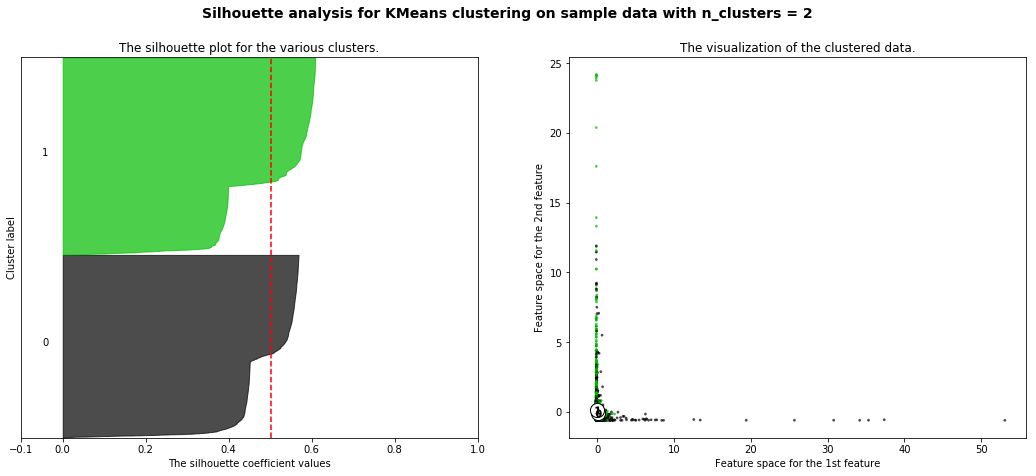

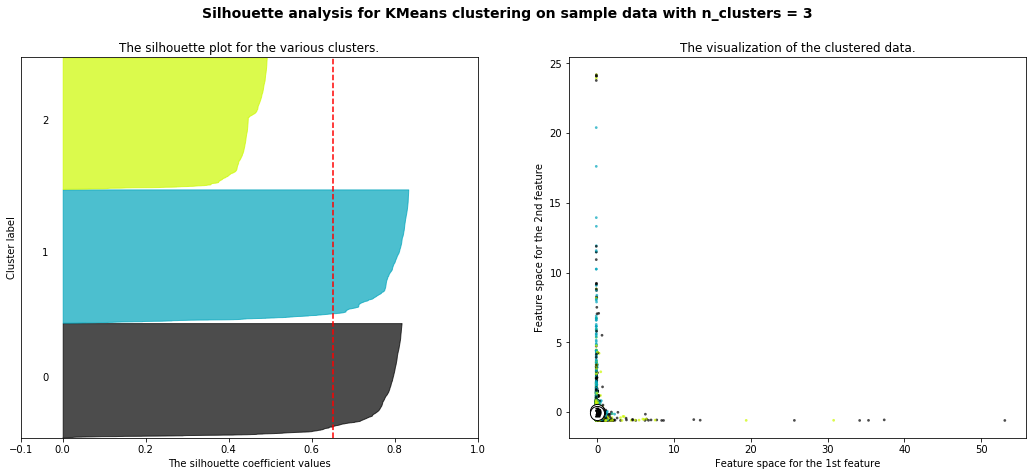

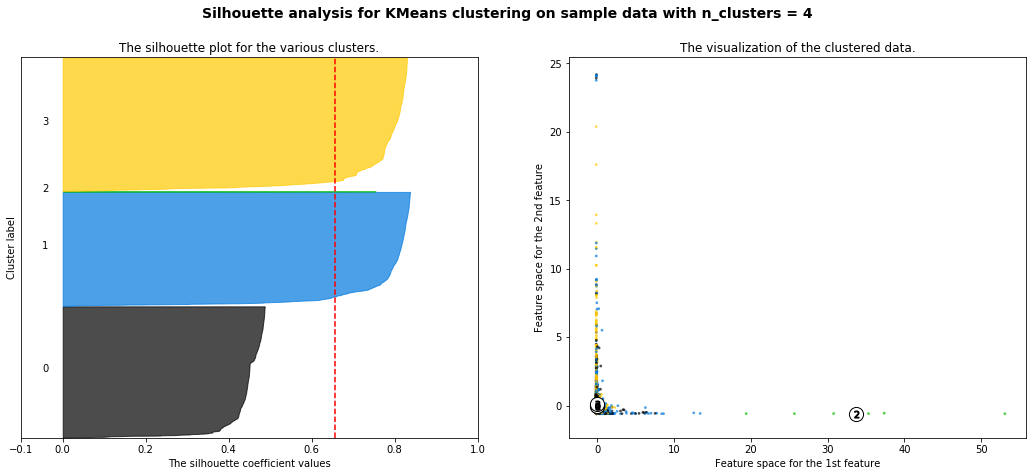

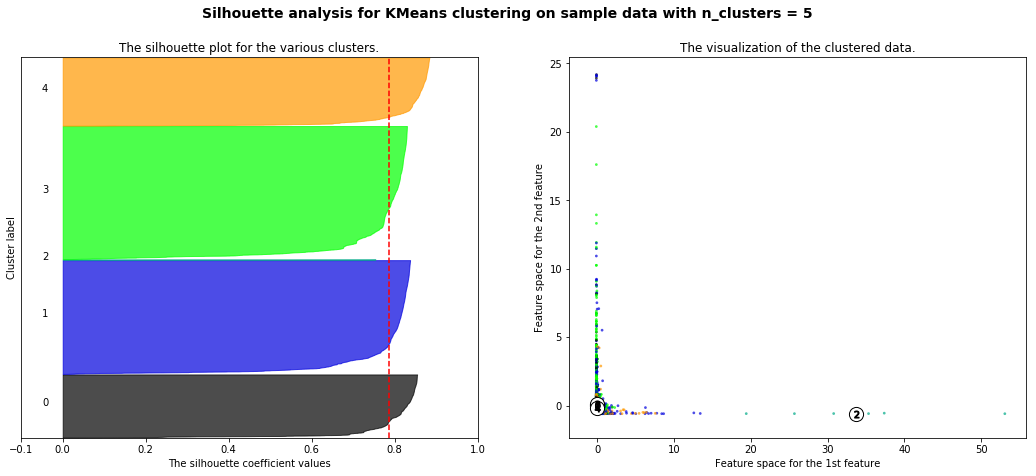

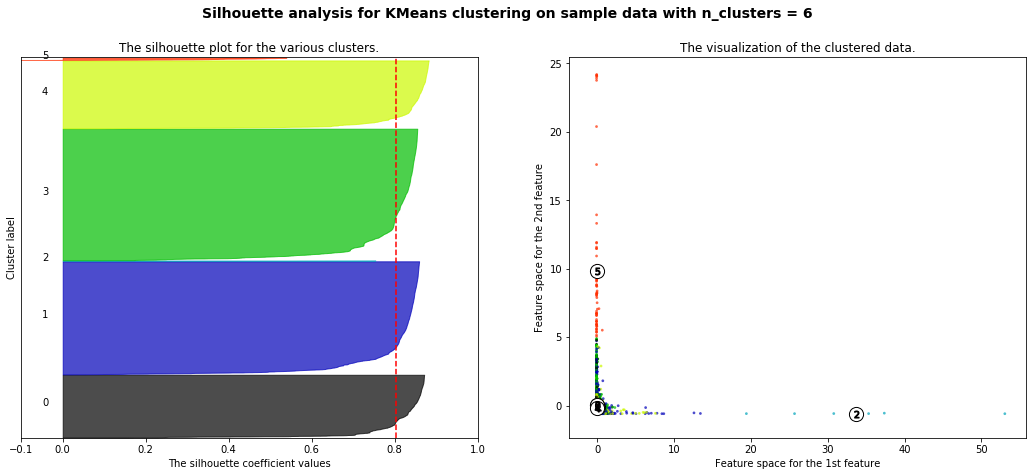

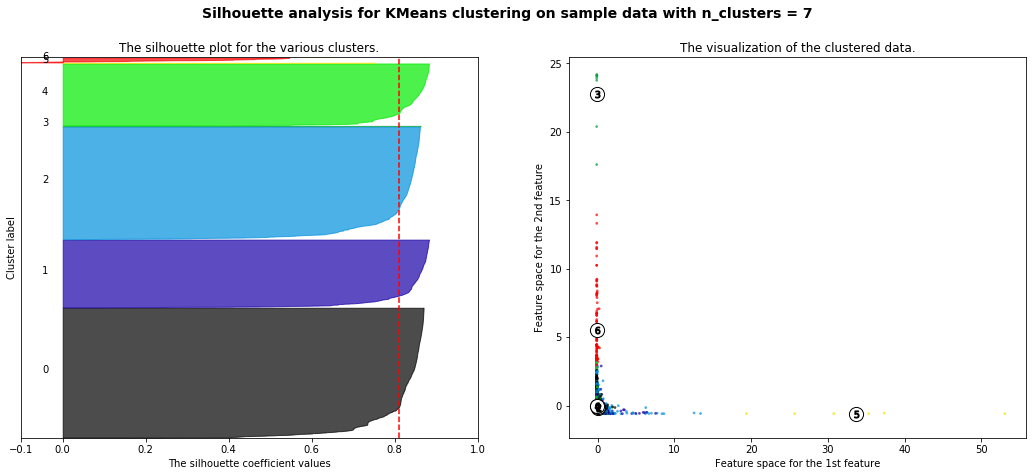

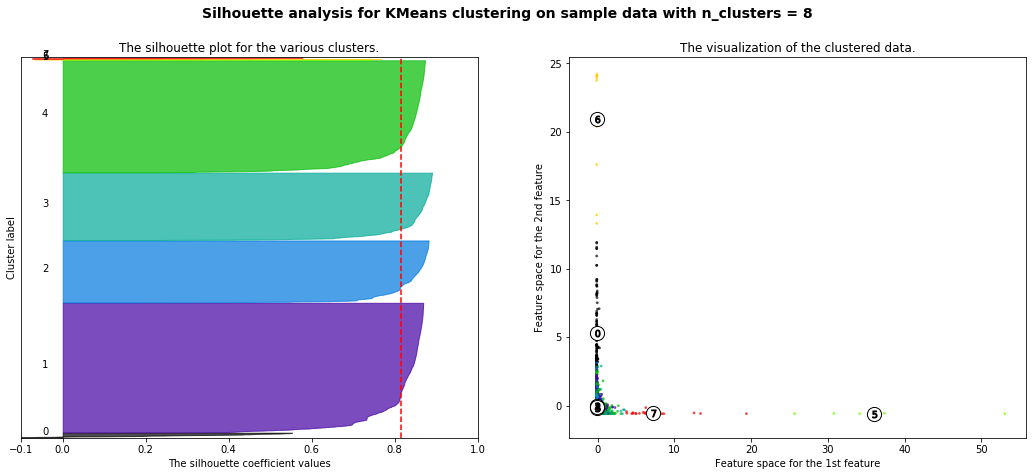

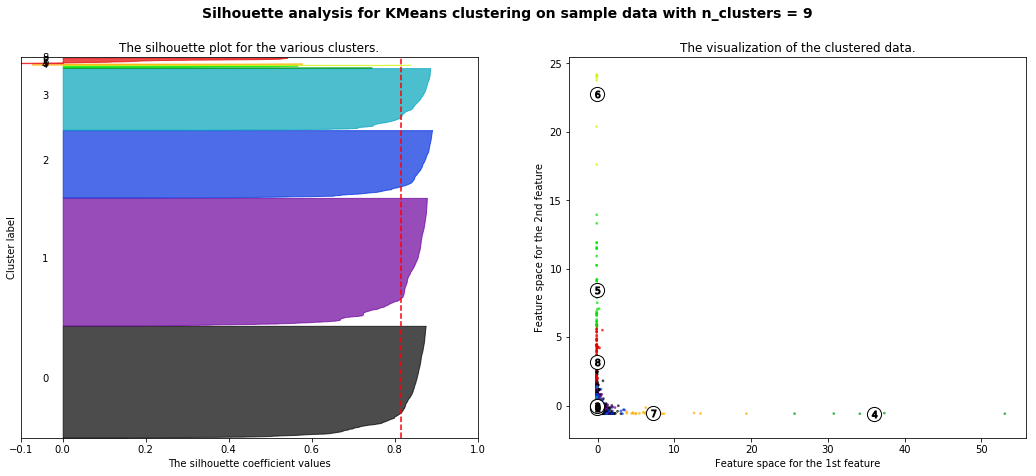

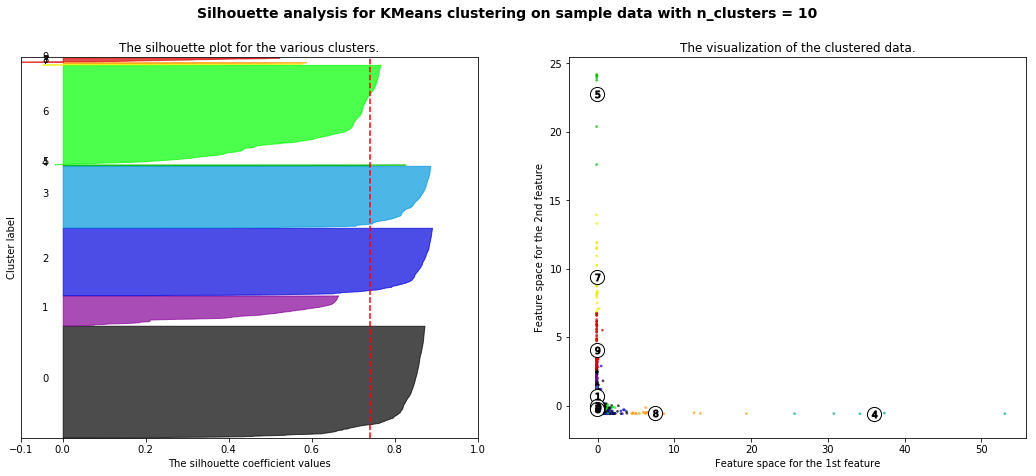

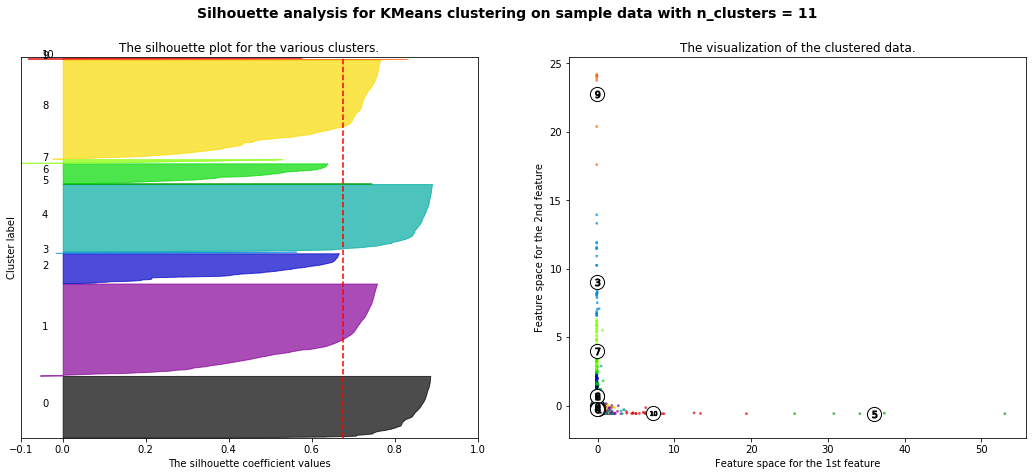

In [18]:
# Silhouette Analysis here

# from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# numeric_data.sample(1000)
X = numeric_data.sample(10000).values
# X = numeric_data.values
# y = model.labels_

range_n_clusters = range(2, 12)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [28]:
# K Means Cluster
model = KMeans(n_clusters=9)
model.fit(numeric_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.004s...
[t-SNE] Computed neighbors for 7000 samples in 0.265s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 0.014748
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.165329
[t-SNE] Error after 300 iterations: 1.506151
t-SNE done! Time elapsed: 49.17068004608154 seconds


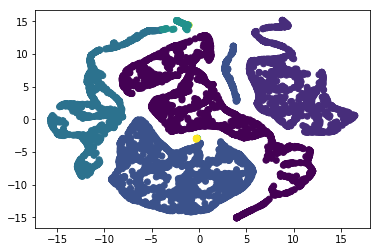

In [30]:
import time

from sklearn.manifold import TSNE

n_sne = 7000
numeric_data['Label'] = model.labels_
my_data = numeric_data.sample(n_sne)
colored_labels = my_data['Label'].values
numeric_data.drop(['Label'], axis = 1)

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(my_data.values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_x = tsne_results[:,0]
df_y = tsne_results[:,1]

chart = plt.scatter(df_x, df_y, c=colored_labels)

## Centers of Labeled Data

In [84]:
# look at centers of labeled data
labeled_data = output.copy()
labeled_data['Label'] = model.labels_
labeled_centers = labeled_data.groupby(['Label']).mean()
centers = labeled_centers[list(labeled_centers)[2:]].copy()

# get observation counts
label_counts = labeled_data['Label'].value_counts().to_frame()
label_counts.sort_index(inplace=True)
centers['Cluster Size'] = label_counts.values
centers

,LINE_SRVC_CNT,BENE_UNIQUE_CNT,BENE_DAY_SRVC_CNT,AVERAGE_MEDICARE_ALLOWED_AMT,AVERAGE_SUBMITTED_CHRG_AMT,AVERAGE_MEDICARE_PAYMENT_AMT,AVERAGE_MEDICARE_STANDARD_AMT,Cluster Size
Label,,,,,,,,
0,104.442126,69.930549,98.536308,97.035830,427.789742,74.729808,70.609758,28754
1,148.234311,53.608036,108.068402,72.931282,182.343803,55.255352,53.412718,15555
2,165.607043,71.222073,132.780500,82.544742,220.353354,62.002139,60.014636,24492
3,95.021136,63.689577,90.328097,97.525317,415.359917,75.029566,70.720644,13749
4,47.522936,28.207339,36.222018,1049.666867,5165.295933,823.674895,741.474309,1090
5,141664.000000,48.666667,283.666667,0.653901,2.223333,0.508630,0.510047,3
6,50782.650000,99.300000,227.200000,2.552057,5.942515,1.993322,2.001396,20
7,34.220588,21.926471,33.602941,3520.967704,10091.327890,2743.535359,2662.465872,68
8,11447.535714,143.833333,507.196429,12.057700,31.937868,9.411097,9.339226,168


In [36]:
labeled_data[labeled_data['Label'] == 5]['PLACE_OF_SERVICE'].value_counts()

O    3
Name: PLACE_OF_SERVICE, dtype: int64

In [54]:
# look at gender distribution per label
for i in range(9):
    print("--------------Cluster", i, "---------------------")
    print(labeled_data[labeled_data['Label'] == i]['PLACE_OF_SERVICE'].value_counts())
    print(labeled_data[labeled_data['Label'] == i]['NPPES_PROVIDER_GENDER'].value_counts())
    # print(labeled_data[labeled_data['Label'] == i]['NPI'].nunique())
    print(labeled_data[labeled_data['Label'] == i]['HCPCS_CODE'].value_counts())

--------------Cluster 0 ---------------------
F    28754
Name: PLACE_OF_SERVICE, dtype: int64
M    28754
Name: NPPES_PROVIDER_GENDER, dtype: int64
99232    1417
99223    1120
99233    1042
99222     984
99291     593
99238     542
99213     497
99231     483
99214     481
99284     410
99285     404
99221     400
99283     391
99239     379
93010     323
99217     256
99220     248
99215     222
99204     221
00740     196
71010     192
99203     182
71020     175
74000     167
99308     167
36620     161
99219     158
99309     156
00810     156
70450     154
         ... 
29540       1
44799       1
76516       1
37242       1
66180       1
92979       1
74450       1
64642       1
76873       1
22305       1
29515       1
78813       1
68801       1
10021       1
22511       1
67041       1
31237       1
75822       1
74245       1
78290       1
11981       1
62319       1
11046       1
32666       1
01916       1
20220       1
01270       1
19371       1
11000       1
26320       1

In [82]:
demographic_info = labeled_data[['NPI','NPPES_PROVIDER_GENDER','Label', 'PLACE_OF_SERVICE']].drop_duplicates()

In [83]:
for i in range(9):
    selected_data = demographic_info[demographic_info['Label'] == i]
    print(selected_data['NPPES_PROVIDER_GENDER'].value_counts())
    print(selected_data['PLACE_OF_SERVICE'].value_counts())

M    3588
Name: NPPES_PROVIDER_GENDER, dtype: int64
F    3588
Name: PLACE_OF_SERVICE, dtype: int64
F    2917
Name: NPPES_PROVIDER_GENDER, dtype: int64
O    2917
Name: PLACE_OF_SERVICE, dtype: int64
M    3314
Name: NPPES_PROVIDER_GENDER, dtype: int64
O    3314
Name: PLACE_OF_SERVICE, dtype: int64
F    2503
Name: NPPES_PROVIDER_GENDER, dtype: int64
F    2503
Name: PLACE_OF_SERVICE, dtype: int64
M    538
F    102
Name: NPPES_PROVIDER_GENDER, dtype: int64
F    512
O    128
Name: PLACE_OF_SERVICE, dtype: int64
M    1
F    1
Name: NPPES_PROVIDER_GENDER, dtype: int64
O    2
Name: PLACE_OF_SERVICE, dtype: int64
M    12
F     4
Name: NPPES_PROVIDER_GENDER, dtype: int64
O    16
Name: PLACE_OF_SERVICE, dtype: int64
M    49
F    14
Name: NPPES_PROVIDER_GENDER, dtype: int64
O    43
F    20
Name: PLACE_OF_SERVICE, dtype: int64
M    72
F    27
Name: NPPES_PROVIDER_GENDER, dtype: int64
O    98
F     1
Name: PLACE_OF_SERVICE, dtype: int64


In [55]:
demographic_info['NPPES_PROVIDER_GENDER'].value_counts()

M    7554
F    5566
Name: NPPES_PROVIDER_GENDER, dtype: int64